In [5]:
# Note: After you run this cell, the training and test data will be available in
# the file browser. (Click the folder icon on the left to view it)
#
# If you don't see the data after the cell completes, click the refresh button
# in the file browser (folder icon with circular arrow)

# First, let's download and unzip the data
!echo "Downloading files..."
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training1.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training2.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/holdout.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout_answers.csv

!echo "Unzipping files..."
!unzip -q /content/training1.zip
!unzip -q /content/training2.zip
!unzip -q /content/holdout.zip
!unzip -q /content/mini_holdout.zip

# Combine the two traning directories
!echo "Merging training data..."
!mkdir /content/training
!mv /content/training1/* /content/training
!mv /content/training2/* /content/training

# Cleanup
!echo "Cleaning up..."
!rmdir /content/training1
!rmdir /content/training2
!rm training1.zip
!rm training2.zip
!rm holdout.zip
!rm mini_holdout.zip

!echo "Data ready."

Unzipping files...
Merging training data...
Cleaning up...
Data ready.


In [6]:
!pip install coremltools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 9.4 MB/s eta 0:00:00


In [7]:
# Import libraries
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import coremltools

In [8]:
# We're using keras' ImageDataGenerator class to load our image data.
# See (https://keras.io/api/preprocessing/image/#imagedatagenerator-class) for details
#
# A couple of things to note:
# 1. We're specifying a number for the seed, so we'll always get the same shuffle and split of our images.
# 2. Class names are inferred automatically from the image subdirectory names.
# 3. We're splitting the training data into 80% training, 20% validation.


training_dir = '/content/training/'
image_size = (224, 224)  # ResNet50 expects 224x224 images

# Split up the training data images into training and validation sets
# We'll use an ImageDataGenerator to do the splits
# ImageDataGenerator can also be used to do preprocessing and augmentation on the files as can be seen with rescale

# tf.keras.preprocessing.image.ImageDataGenerator(
#     featurewise_center=False,
#     samplewise_center=False,
#     featurewise_std_normalization=False,
#     samplewise_std_normalization=False,
#     zca_whitening=False,
#     zca_epsilon=1e-06,
#     rotation_range=0,
#     width_shift_range=0.0,
#     height_shift_range=0.0,
#     brightness_range=None,
#     shear_range=0.0,
#     zoom_range=0.0,
#     channel_shift_range=0.0,
#     fill_mode='nearest',
#     cval=0.0,
#     horizontal_flip=False,
#     vertical_flip=False,
#     rescale=None,
#     preprocessing_function=None,
#     data_format=None,
#     validation_split=0.0,
#     interpolation_order=1,
#     dtype=None
# )



train_datagen = ImageDataGenerator(
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        rotation_range=20,
        rescale=1./255,
        validation_split=.2,
        )
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2
        )

train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size=image_size,
        subset="training",
        batch_size=32,
        class_mode='sparse',
        seed=42, shuffle=True)
validation_generator = validation_datagen.flow_from_directory(
        training_dir,
        target_size=image_size,
        batch_size=32,
        class_mode='sparse',
        subset="validation",
        seed=42)


Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


In [9]:
#these might come in handy
target_names = ['Speed_20', 'Speed_30', 'Speed_50', 'Speed_60', 'Speed_70',
               'Speed_80','Speed_Limit_Ends', 'Speed_100', 'Speed_120', 'Overtaking_Prohibited',
               'Overtakeing_Prohibited_Trucks', 'Crossroad_Ahead', 'Priority_Road_Ahead', 'Yield', 'STOP',
               'Entry_Forbidden', 'Trucks_Forbidden', 'No_Entry(one-way traffic)', 'Cars_Prohibited(!)', 'Left_Curve_Ahead',
               'Right_Curve_Ahead', 'Bends_Left_Then_Right', 'Poor_Surface_Ahead', 'Slippery_Surface_Ahead', 'Road_Narrows_On_Right',
               'Roadwork_Ahead', 'Traffic_Light_Ahead', 'Warning_Pedestrians', 'Warning_Children', 'Warning_Bikes',
               'Uncontrolled_Crossroad', 'Deer_Crossing', 'End_Previous_Limitation', 'Turning_Right_Compulsory', 'Turning_Left_Compulsory',
               'Ahead_Only', 'Straight_Or_Right_Mandatory', 'Straight_Or_Left_Mandatory', 'Passing_Right_Compulsory', 'Passing_Left_Compulsory',
               'Roundabout', 'End_Overtaking_Prohibition', 'End_Overtaking_Prohibition_Trucks']

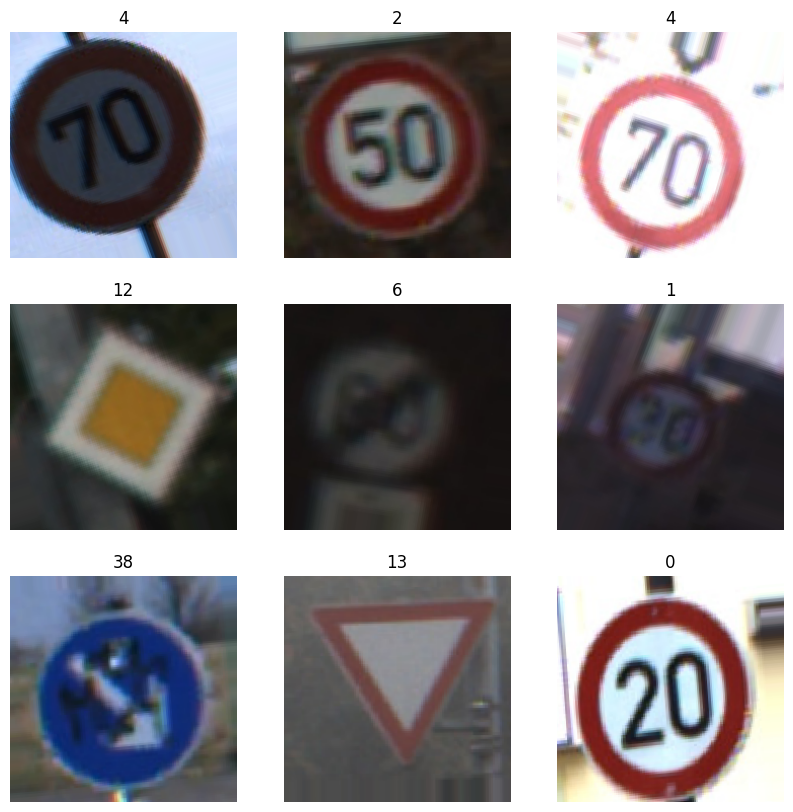

In [10]:
# View 9 images and their class labels
plt.figure(figsize=(10, 10))
images, labels = next(train_generator)
batch_size = images.shape[0]

for i in range(min(9, batch_size)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images[i] * 255).astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

plt.show()

# Training the model using ResNet50

In [11]:
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2

In [12]:
# Make the base model
model = models.Sequential()

image_shape = (224, 224, 3)

# first layer
model.add(layers.Conv2D(100, (5, 5),
                        strides=1,
                        activation='relu',
                        padding='valid',
                        input_shape=image_shape))

# max pooling layer (2x2 pooling)
model.add(layers.MaxPooling2D(pool_size=(3, 3),strides=(2,2), padding='same'))

# second layer
model.add(layers.Conv2D(50, (3, 3), strides=1, activation='relu', padding='valid'))

# another max pooling layer (2x2 pooling)
model.add(layers.MaxPooling2D(pool_size=(3, 3),strides=(2,2), padding='same'))

# format the model
model.add(layers.Flatten()) # turn it into 1D before dense layers
model.add(layers.Dense(500, activation='relu')) # 500 neurons
model.add(layers.Dense(43)) # final layer has same number of neurons as classes

# Compile the model
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,  # Adjust the number of epochs as needed
)

Epoch 1/10
980/980 [==============================] - 459s 456ms/step - loss: 2.0961 - accuracy: 0.3815 - val_loss: 1.8589 - val_accuracy: 0.4533
Epoch 2/10
980/980 [==============================] - 438s 447ms/step - loss: 1.3944 - accuracy: 0.5487 - val_loss: 1.6715 - val_accuracy: 0.5189
Epoch 3/10
980/980 [==============================] - 435s 444ms/step - loss: 1.0995 - accuracy: 0.6362 - val_loss: 1.6240 - val_accuracy: 0.5665
Epoch 4/10
980/980 [==============================] - 435s 444ms/step - loss: 0.9104 - accuracy: 0.6963 - val_loss: 1.6459 - val_accuracy: 0.5719
Epoch 5/10
980/980 [==============================] - 440s 449ms/step - loss: 0.7805 - accuracy: 0.7416 - val_loss: 1.6003 - val_accuracy: 0.6138
Epoch 6/10
980/980 [==============================] - 440s 449ms/step - loss: 0.7026 - accuracy: 0.7675 - val_loss: 1.6140 - val_accuracy: 0.6091
Epoch 7/10
980/980 [==============================] - 435s 444ms/step - loss: 0.6242 - accuracy: 0.7952 - val_loss: 1.6401 -

# Saving and Loading the model

In [13]:
# Import Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# Define the path to save the model
model_path = '/content/drive/My Drive/Machine Learning Group 5/Signs (CNN)/scratch_mastre_resnet.h5'

# Save the model
model.save(model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
from tensorflow.keras.models import load_model

# Define the path to the saved model
#model_path = 'mastre_resnet.h5'

# Load the model
#model = load_model(model_path)

# Saving the model as CoreML (Apple)


In [21]:
core_model = coremltools.convert(model, convert_to="mlprogram", inputs=[coremltools.TensorType(shape=[1, 224, 224, 3])])

model.save("/content/drive/My Drive/Machine Learning Group 5/Signs (CNN)/resnet50_roadsigns.mlprogram")

Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00, 37.83 passes/s]


# Plotting the model

In [22]:
# Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

# Generate predictions
val_generator = validation_datagen.flow_from_directory(
    training_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='sparse',
    subset="validation",
    seed=42,
    shuffle=False  # Important to keep the order to match predictions with labels
)

# Predict the labels
predictions = model.predict(val_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=target_names)
print(report)

246/246 [==============================] - 13s 54ms/step - loss: 1.5785 - accuracy: 0.6494
Validation Loss: 1.5785281658172607
Validation Accuracy: 0.6494069695472717
Found 7841 images belonging to 43 classes.
246/246 [==============================] - 13s 52ms/step
                                   precision    recall  f1-score   support

                         Speed_20       0.67      0.24      0.35        42
                         Speed_30       0.45      0.53      0.49       444
                         Speed_50       0.44      0.56      0.49       450
                         Speed_60       0.38      0.46      0.42       282
                         Speed_70       0.39      0.32      0.35       396
                         Speed_80       0.43      0.29      0.35       372
                 Speed_Limit_Ends       0.89      0.77      0.83        84
                        Speed_100       0.17      0.16      0.17       288
                        Speed_120       0.68      0.70   

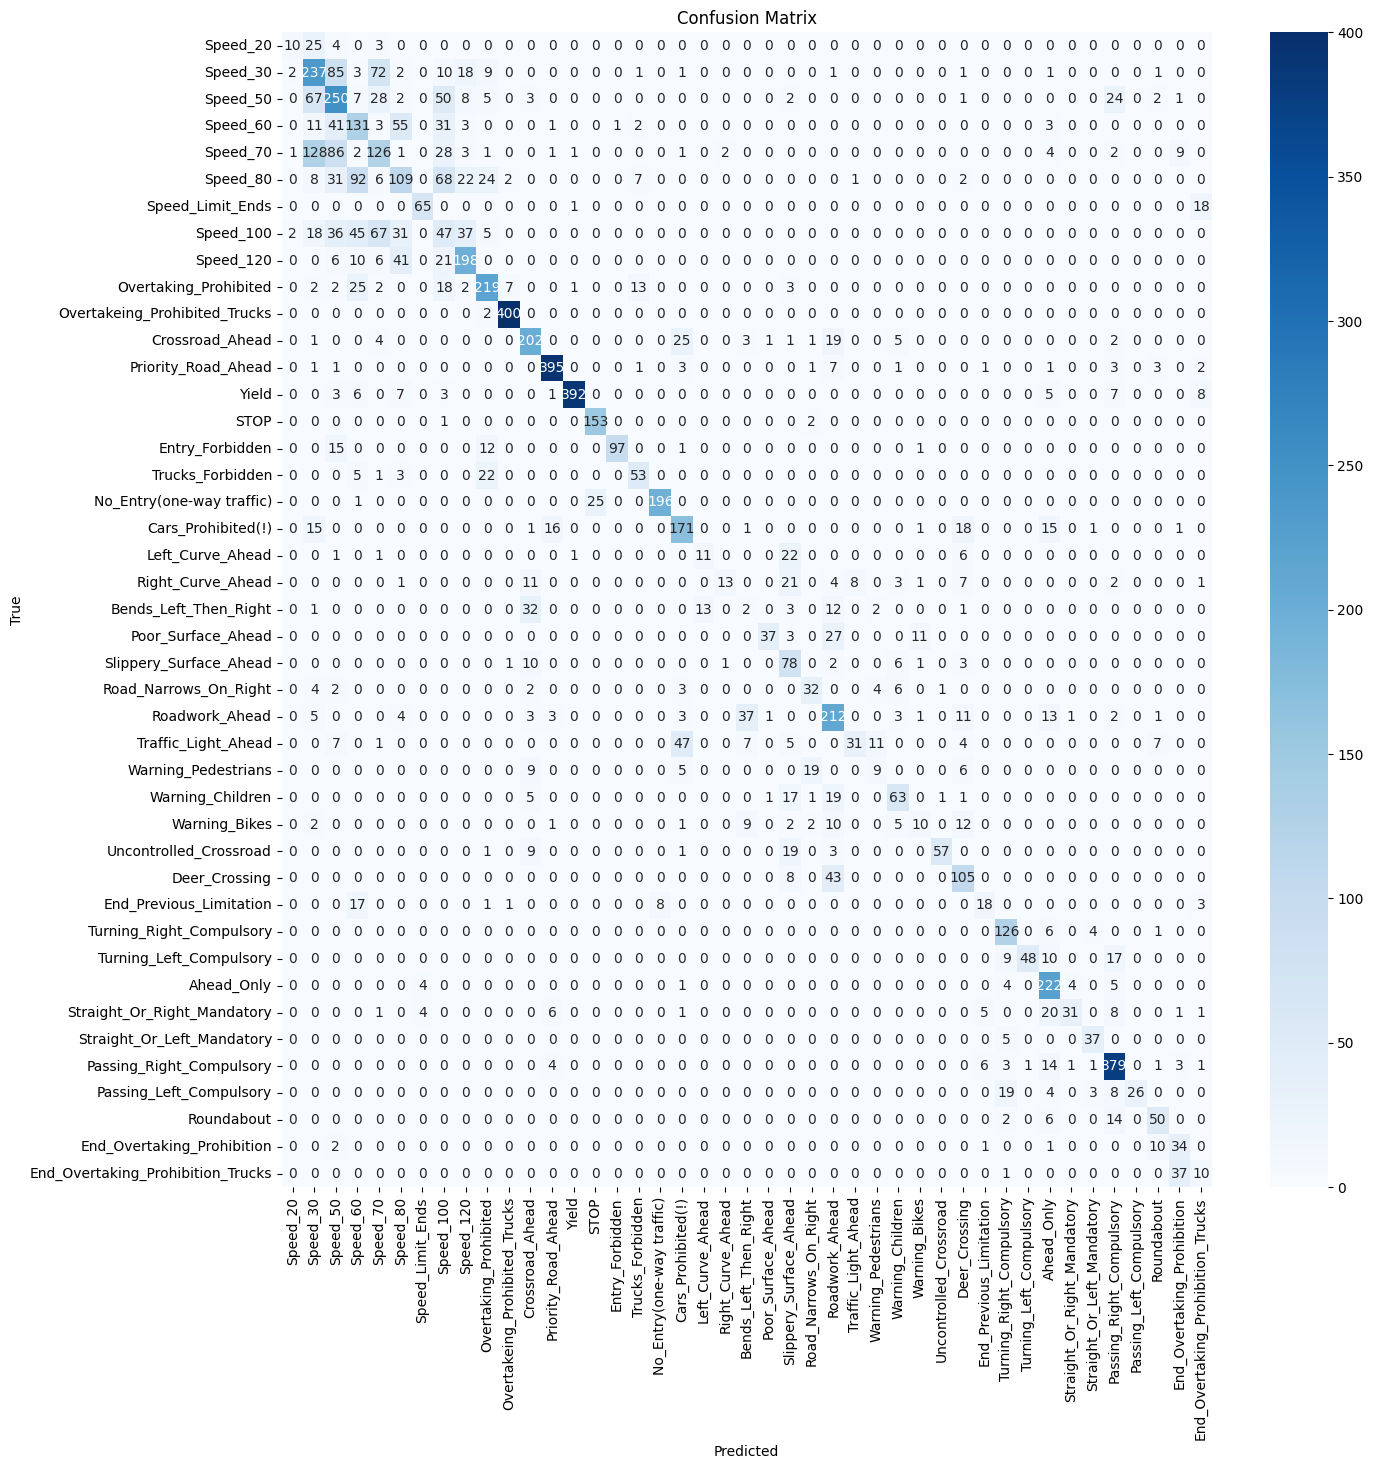

In [23]:
# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Testing the model
Once you have built and trained your model, the next step is to run the mini holdout images through it and see how well your model does at making predictions for images it has never seen before.

Since loading these images and formatting them for the model can be tricky, you may find the following code useful. This code only uses your model to predict the class label for a given image. You'll still need to compare those predictions to the "ground truth" class labels in `mini_holdout_answers.csv` to evaluate how well the model does.

Previously, you were given a file that would check your results. This time you're given the answers to the first mini holdout dataset. You'll need to compare those predictions against the "ground truth" class labels in `mini_holdout_answers.csv` to evaluate how well the model does.

Make sure to use the insights gained from the mini hold out dataset in your executive summary.


```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['mini_holdout'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```



##Mini Hold out Dataset


Once you feel confident, you will need to predict for the full holdout dataset using the following code, and submit your csv file:

```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['holdout'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```

Found 201 images belonging to 1 classes.
7/7 [==============================] - 1s 110ms/step
Accuracy: 72.14%
Classification Report:
                                   precision    recall  f1-score   support

                         Speed_20       0.00      0.00      0.00         0
                         Speed_30       0.67      0.55      0.60        11
                         Speed_50       0.27      0.38      0.32         8
                         Speed_60       0.57      0.40      0.47        10
                         Speed_70       0.80      0.44      0.57         9
                         Speed_80       0.50      0.40      0.44         5
                 Speed_Limit_Ends       1.00      0.33      0.50         3
                        Speed_100       0.46      0.75      0.57         8
                        Speed_120       0.44      0.67      0.53         6
            Overtaking_Prohibited       0.90      0.90      0.90        10
    Overtakeing_Prohibited_Trucks       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

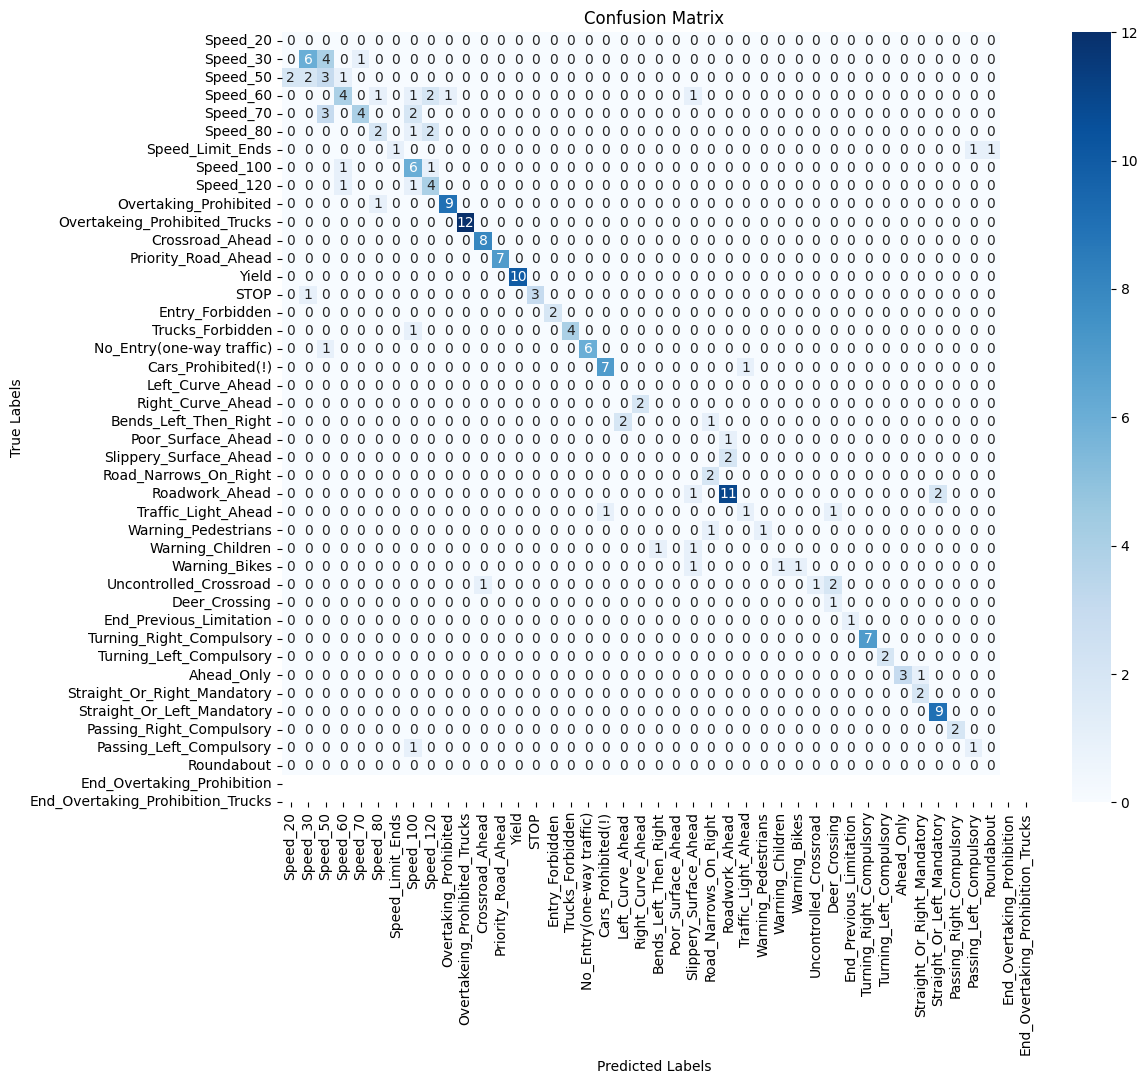

In [24]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, r2_score

# Path to the mini holdout dataset and answers file
test_dir = '/content/'
answers_file = '/content/mini_holdout_answers.csv'

# Create an ImageDataGenerator for the mini holdout dataset
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    classes=['mini_holdout'],
    target_size=image_size,
    class_mode='sparse',
    shuffle=False,
    batch_size=32  # Adjust batch size as needed
)

# Predict probabilities for the mini holdout dataset
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]

# Load the ground truth labels from the CSV file
answers_df = pd.read_csv(answers_file)
true_labels = answers_df['ClassId'].values

# Ensure labels match actual classes present in data
unique_classes = np.unique(np.concatenate((true_labels, predictions)))
labels = sorted(unique_classes)

# Compare predictions to the ground truth
accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Generate a classification report
report = classification_report(true_labels, predictions, labels=labels, target_names=[target_names[i] for i in labels])
print('Classification Report:')
print(report)

# Generate and display a confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [25]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, r2_score
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['holdout'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]

# Ensure labels match actual classes present in data
unique_classes = np.unique(np.concatenate((true_labels, predictions)))
labels = sorted(unique_classes)

# Format and export data
predictions_table = pd.DataFrame(predictions, columns=['predictions'])
predictions_table.to_csv('team5-module5-predictions.csv', index=False)
print(predictions_table.value_counts())

Found 12630 images belonging to 1 classes.
395/395 [==============================] - 22s 56ms/step
predictions
7              808
38             801
25             737
13             706
4              702
1              698
2              666
10             638
12             595
8              545
3              541
11             465
9              463
18             378
5              361
35             339
17             300
31             262
14             245
33             225
15             187
26             182
36             166
23             165
41             143
6              142
16             115
40             114
34             108
20              97
28              81
30              73
24              71
32              63
39              62
42              60
37              59
22              58
29              54
19              54
27              49
21              36
0               16
Name: count, dtype: int64
